Jets as graphs

*  Please choose a graph-based GNN model of your choice to classify (quark/gluon) jets. Proceed as follows:

  1. Convert the images into a point cloud dataset by only considering the non-zero pixels for every event.
  2. Cast the point cloud data into a graph representation by coming up with suitable representations for nodes and edges.
  3. Train your model on the obtained graph representations of the jet events.
*  Discuss the resulting performance of the chosen architecture.


# Importing Dependencies

In [ ]:
import os
import torch
import warnings
warnings.filterwarnings("ignore")

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-lightning==1.7.0
!pip install torchviz

In [ ]:
import numpy as np
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import torch.optim as optim

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool
from torch.nn import Linear

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Load the dataset from the HDF5 file
with h5py.File('/content/drive/MyDrive/quark-gluon_data-set_n139306.hdf5', 'r') as f:
    X_jets = np.array(f['X_jets'][:20000])
    labels = np.array(f['y'][:20000])


In [ ]:
X_jets.shape

(20000, 125, 125, 3)

# Data Visualization

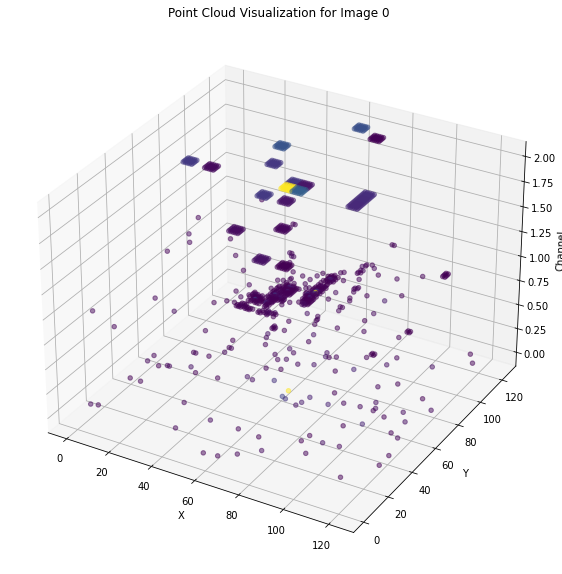

In [ ]:
# Store the point clouds for all images in a list
point_clouds = []

for i in range(X_jets.shape[0]):
    # Extract the non-zero pixel coordinates and values for each channel
    non_zero_Tracks = np.nonzero(X_jets[i, :, :, 0])
    non_zero_ECAL = np.nonzero(X_jets[i, :, :, 1])
    non_zero_HCAL = np.nonzero(X_jets[i, :, :, 2])
    coords_Tracks = np.column_stack(non_zero_Tracks)
    coords_ECAL = np.column_stack(non_zero_ECAL)
    coords_HCAL = np.column_stack(non_zero_HCAL)

    #For visualization placing Tracks, ECAL, HCAL on z = 0,1,2 respectively. However when training 2D surface would be used i.e z=0 for all channels
    values_Tracks = X_jets[i, non_zero_Tracks[0], non_zero_Tracks[1], 0]
    values_ECAL = X_jets[i, non_zero_ECAL[0], non_zero_ECAL[1], 1]
    values_HCAL = X_jets[i, non_zero_HCAL[0], non_zero_HCAL[1], 2]

    coords_Tracks = np.hstack((coords_Tracks, np.zeros((coords_Tracks.shape[0], 1))))
    coords_ECAL = np.hstack((coords_ECAL, np.zeros((coords_ECAL.shape[0], 1))))
    coords_HCAL = np.hstack((coords_HCAL, np.zeros((coords_HCAL.shape[0], 1))))

    # Store the point cloud for this image in the list
    point_clouds.append({'tracks': (coords_Tracks, values_Tracks), 'ECAL': (coords_ECAL, values_ECAL), 'HCAL': (coords_HCAL, values_HCAL)})

# Plot the point cloud for the first image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Point cloud for the first image
point_cloud = point_clouds[0]

ax.scatter(point_cloud['tracks'][0][:, 0], point_cloud['tracks'][0][:, 1], point_cloud['tracks'][0][:, 2], c=point_cloud['tracks'][1], cmap='viridis', alpha=0.5)
ax.scatter(point_cloud['ECAL'][0][:, 0], point_cloud['ECAL'][0][:, 1], point_cloud['ECAL'][0][:, 2] + 1, c=point_cloud['ECAL'][1], cmap='viridis', alpha=0.5)
ax.scatter(point_cloud['HCAL'][0][:, 0], point_cloud['HCAL'][0][:, 1], point_cloud['HCAL'][0][:, 2]+ 2, c=point_cloud['HCAL'][1], cmap='viridis', alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Channel')
ax.set_title('Point Cloud Visualization for Image 0')

plt.show()

del non_zero_Tracks
del non_zero_ECAL
del non_zero_HCAL
del coords_Tracks
del coords_ECAL
del coords_HCAL
del values_Tracks
del values_ECAL
del values_HCAL
del point_clouds
del point_cloud

# Point Cloud to graph representation

In [ ]:
# Reshape the data to be compatible with torch_geometric
data = X_jets.reshape((-1, X_jets.shape[1]*X_jets.shape[2], 3))
non_black_pixels_mask = np.any(data != [0., 0., 0.], axis=-1)
node_list = []
for i, x in enumerate(data):
    node_list.append(x[non_black_pixels_mask[i]])

# Create the dataset of graphs
dataset = []
for i, nodes in enumerate(node_list):
    # edges = kneighbors_graph(nodes, 10, mode='connectivity', include_self=True)
    # edges = kneighbors_graph(nodes, 4, mode='connectivity', include_self=True)
    edges = kneighbors_graph(nodes, 2, mode='connectivity', include_self=True)
    c = edges.tocoo()
    edge_list = torch.from_numpy(np.vstack((c.row, c.col))).type(torch.long)
    edge_weight = torch.from_numpy(c.data.reshape(-1, 1))
    y = torch.tensor([int(labels[i])], dtype=torch.long)
    data = Data(x=torch.from_numpy(nodes), edge_index=edge_list, edge_attr=edge_weight, y=y)
    dataset.append(data)

train_loader = DataLoader(dataset[:8000], batch_size=32, shuffle=True)
test_loader = DataLoader(dataset[8000:9000], batch_size=32, shuffle=False)
val_loader = DataLoader(dataset[9000:], batch_size=32, shuffle=False)

In [ ]:
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')

print(dataset[0])

Number of nodes: 884
Number of edges: 1768
Number of node features: 3
Number of edges features: 1
Data(x=[884, 3], edge_index=[2, 1768], edge_attr=[1768, 1], y=[1])


In [ ]:
del X_jets
del labels

In [ ]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

250
32
344


# Building and Training the Model

In [ ]:
import torch.utils.data as data

class GraphSAGE(torch.nn.Module):
    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.3):
        super().__init__()
        torch.manual_seed(17)

        self.conv1 = SAGEConv(c_in, c_hidden)
        self.conv2 = SAGEConv(c_hidden, 2*c_hidden)
        self.conv3 = SAGEConv(2*c_hidden, 4*c_hidden)

        self.lin1 = Linear(4*c_hidden, 32*c_out)
        self.lin2 = Linear(32*c_out, 8*c_out)
        self.lin3 = Linear(8*c_out, c_out)
        self.dp_rate_linear = dp_rate_linear

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # classifier
        x = F.dropout(x, p=self.dp_rate_linear, training=self.training)
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=self.dp_rate_linear, training=self.training)
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)

        return x

# print(model)

class GraphLevelGNN(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphSAGE(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        # print(data.x.shape, data.edge_index.shape, data.batch.shape)

        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)

        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]

        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log('val_loss', loss, on_epoch=True, prog_bar=False)
        self.log('val_acc', acc, on_epoch=True, prog_bar=False)

    def test_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="test")
        self.log('test_loss', loss, on_epoch=True, prog_bar=False)
        self.log('test_acc', acc, on_epoch=True, prog_bar=False)

In [ ]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(17)

    trainer = pl.Trainer(gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=40)

    # Check whether pretrained model exists. If yes, load it and skip training
    model = GraphLevelGNN(**model_kwargs)
    print(model)
    trainer.fit(model, train_loader, val_loader)
    model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation and test set
    # train_result = trainer.test(model, dataloaders=train_loader, verbose=False)
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "valid": val_result[0]['test_acc']}
    return trainer, model, result


In [ ]:
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer, model, result = train_graph_classifier(model_name="GraphSAGE",c_in=3, c_hidden=32, c_out=2)

INFO:pytorch_lightning.utilities.seed:Global seed set to 17
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GraphSAGE        | 30.2 K
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
30.2 K    Trainable params
0         Non-tra

GraphLevelGNN(
  (model): GraphSAGE(
    (conv1): SAGEConv(3, 32, aggr=mean)
    (conv2): SAGEConv(32, 64, aggr=mean)
    (conv3): SAGEConv(64, 128, aggr=mean)
    (lin1): Linear(in_features=128, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=16, bias=True)
    (lin3): Linear(in_features=16, out_features=2, bias=True)
  )
  (loss_module): CrossEntropyLoss()
)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Testing: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

In [ ]:
print(model)

GraphLevelGNN(
  (model): GraphSAGE(
    (conv1): SAGEConv(3, 32, aggr=mean)
    (conv2): SAGEConv(32, 64, aggr=mean)
    (conv3): SAGEConv(64, 128, aggr=mean)
    (lin1): Linear(in_features=128, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=16, bias=True)
    (lin3): Linear(in_features=16, out_features=2, bias=True)
  )
  (loss_module): CrossEntropyLoss()
)


In [ ]:
print(result)   # For k = 10

{'test': 0.7138404846191406, 'valid': 0.6996651291847229}


In [ ]:
print(result)   # For k = 4

{'test': 0.7121071219444275, 'valid': 0.6962995529174805}


In [ ]:
print(result)   # For k = 2

{'test': 0.7198882699012756, 'valid': 0.6929576396942139}


| Model | Test Accuracy | Validation Accuracy |
| :-------: | :----: | :----: |
| GraphSAGE (k=10) | 0.7138 | 0.6996 |
| GraphSAGE (k=4) | 0.7121 | 0.6962 |
| GraphSAGE (k=2) |  0.7198 | 0.6929 |


# Discussion

*  Differences in accuracy between the different values of `k` are relatively small, indicating that the chosen model architecture is not very sensitive to changes in the value of `k`.  (`k` is the number of nearest neighbors for each node)

* As GraphSAGE works by aggregating node features from its neighbors and generating embeddings for each node it is only able to understand the local neighborhood of each node, which may not capture the full structure of the graph.

* Though it seems to be performing well achieving an accuracy of around 71%, alternate GNN models may also be used such as Graph Attention Networks (GATs) and Graph Convolutional Networks (GCNs) which might help addressing this issue by incorporating information from distant nodes as well. These alternate models would be susceptable to issues relating to scalability, choice of `k` and other hyperparameters.

* As GraphSAGE can be applied to large-scale graphs and is computationally efficient due to its use of neighborhood aggregation it will be well-suited if scalability is a concern. Therefore, trade-off between accuracy and computational efficiency will need to be considered when choosing a GNN model for the particular task.


# References

1. https://arxiv.org/pdf/1706.02216v4.pdf

2. https://www.researchgate.net/publication/350647409_Graph_Generative_Models_for_Fast_Detector_Simulations_in_High_Energy_Physics

3. https://lightning.ai/docs/pytorch/latest/notebooks/course_UvA-DL/06-graph-neural-networks.html

4. https://mlabonne.github.io/blog/graphsage/

